# DỰ ĐOÁN THIỆT HẠI VỀ NGƯỜI DO THẢM HỌA

Xây dựng mô hình Machine Learning (Gradient Boosting Regressor) để dự đoán số người chết do thảm họa thiên nhiên.

**Input:** country, disaster_type, severity_index, economic_loss_usd, response_time_hours, response_efficiency_score, latitude, longitude

**Output:** casualties (số người chết dự đoán)

## Import thư viện

In [41]:
# Import thu vien

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)

import joblib
import warnings
warnings.filterwarnings('ignore')

# Thiet lap style bieu do
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Import thu vien thanh cong!")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

Import thu vien thanh cong!
pandas version: 2.3.3
numpy version: 2.4.0


## Định nghĩa Class DisasterCasualtyPredictor

In [42]:
# Dinh nghia class DisasterCasualtyPredictor

class DisasterCasualtyPredictor:
    """
    Mo hinh du doan so nguoi bi chet do tham hoa thien nhien
    Su dung thuat toan Gradient Boosting Regressor
    """
    
    def __init__(self, csv_path: str):
        """Khoi tao doi tuong voi duong dan file CSV"""
        self.csv_path = csv_path
        self.df = None
        
        # Du lieu train/test
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None
        
        # Mo hinh va cac thanh phan
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_columns = None
        self.feature_importance_df = None
        
        print("Khoi tao DisasterCasualtyPredictor thanh cong!")
        print(f"File du lieu: {csv_path}")

## Tải dữ liệu

In [43]:
# Phuong thuc load_data

def load_data(self):
    """Tai va kham pha du lieu tu file CSV"""
    print("=" * 80)
    print("BUOC 1: TAI VA KHAM PHA DU LIEU")
    print("=" * 80)
    
    # Doc file CSV
    self.df = pd.read_csv(self.csv_path)
    print(f"\nTai thanh cong {len(self.df):,} ban ghi")
    print(f"Cac cot trong dataset: {list(self.df.columns)}")
    
    # Thong tin kieu du lieu
    print(f"\nTHONG TIN KIEU DU LIEU:")
    print(self.df.dtypes)
    
    # Kiem tra missing values
    print(f"\nKIEM TRA MISSING VALUES:")
    missing = self.df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "Khong co missing values!")
    
    # Lam sach du lieu
    print(f"\nLAM SACH DU LIEU:")
    before_clean = len(self.df)
    
    self.df = self.df[self.df['severity_index'] > 0].copy()
    self.df = self.df[self.df['casualties'] >= 0].copy()
    self.df = self.df[self.df['economic_loss_usd'] >= 0].copy()
    
    after_clean = len(self.df)
    print(f"Truoc lam sach: {before_clean:,} ban ghi")
    print(f"Sau lam sach: {after_clean:,} ban ghi")
    print(f"Da loai bo: {before_clean - after_clean:,} ban ghi khong hop le")
    
    # Thong ke bien target
    print(f"\nTHONG KE BIEN TARGET (CASUALTIES):")
    print(f"Min: {self.df['casualties'].min():.0f} nguoi")
    print(f"Max: {self.df['casualties'].max():.0f} nguoi")
    print(f"Mean: {self.df['casualties'].mean():.2f} nguoi")
    print(f"Median: {self.df['casualties'].median():.0f} nguoi")
    print(f"Std: {self.df['casualties'].std():.2f}")
    
    return self.df

DisasterCasualtyPredictor.load_data = load_data
print("Da dinh nghia phuong thuc load_data()")

Da dinh nghia phuong thuc load_data()


In [44]:
# Khoi tao va tai du lieu

CSV_PATH = "global_disaster_response_2018_2024.csv"
predictor = DisasterCasualtyPredictor(CSV_PATH)
df = predictor.load_data()

Khoi tao DisasterCasualtyPredictor thanh cong!
File du lieu: global_disaster_response_2018_2024.csv
BUOC 1: TAI VA KHAM PHA DU LIEU

Tai thanh cong 50,000 ban ghi
Cac cot trong dataset: ['date', 'country', 'disaster_type', 'severity_index', 'casualties', 'economic_loss_usd', 'response_time_hours', 'aid_amount_usd', 'response_efficiency_score', 'recovery_days', 'latitude', 'longitude']

THONG TIN KIEU DU LIEU:
date                          object
country                       object
disaster_type                 object
severity_index               float64
casualties                     int64
economic_loss_usd            float64
response_time_hours          float64
aid_amount_usd               float64
response_efficiency_score    float64
recovery_days                  int64
latitude                     float64
longitude                    float64
dtype: object

KIEM TRA MISSING VALUES:
Khong co missing values!

LAM SACH DU LIEU:
Truoc lam sach: 50,000 ban ghi
Sau lam sach: 50,000 ban ghi

## Phân tích dữ liệu

In [45]:
# Thong ke tong quat

print("5 DONG DU LIEU DAU TIEN:")
display(df.head())

print("\nTHONG KE MO TA CHO CAC BIEN SO:")
display(df.describe())

5 DONG DU LIEU DAU TIEN:


,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
0,31/1/2021,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557
1,23/12/2018,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194
2,10/8/2020,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978
3,15/9/2022,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350
4,28/9/2022,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137



THONG KE MO TA CHO CAC BIEN SO:


,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
count,50000.000000,50000.000000,5.000000e+04,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.015769,100.591140,5.068593e+06,12.183027,2.500003e+05,87.574025,49.682560,0.231205,0.089889
std,1.942843,65.052064,3.268541e+06,9.259081,1.432275e+05,10.188961,20.098944,34.759662,98.380208
min,1.000000,0.000000,5.273900e+02,1.000000,1.660000e+01,29.750000,2.000000,-59.994000,-169.998000
25%,3.660000,51.000000,2.585513e+06,6.270000,1.429663e+05,83.060000,36.000000,-29.848250,-85.551750
50%,4.990000,91.000000,4.548351e+06,10.510000,2.305365e+05,89.180000,49.000000,0.267500,0.390500
75%,6.340000,138.000000,6.950615e+06,15.450000,3.352259e+05,94.700000,63.000000,30.488250,85.665000
max,10.000000,524.000000,2.445624e+07,63.100000,1.126465e+06,100.000000,112.000000,59.997000,169.999000


In [46]:
# Phan tich casualties theo loai tham hoa

print("CASUALTIES THEO LOAI THAM HOA:")
print("-" * 80)

disaster_stats = df.groupby('disaster_type').agg({
    'casualties': ['count', 'mean', 'sum', 'min', 'max', 'std']
}).round(2)

disaster_stats.columns = ['So vu', 'TB nguoi chet', 'Tong', 'Min', 'Max', 'Std']
disaster_stats = disaster_stats.sort_values('TB nguoi chet', ascending=False)

display(disaster_stats)

print(f"\nTONG QUAN:")
print(f"Tong so loai tham hoa: {df['disaster_type'].nunique()}")
print(f"Loai gay thiet hai nhieu nhat: {disaster_stats['TB nguoi chet'].idxmax()}")
print(f"Loai co nhieu vu nhat: {disaster_stats['So vu'].idxmax()}")

CASUALTIES THEO LOAI THAM HOA:
--------------------------------------------------------------------------------


,So vu,TB nguoi chet,Tong,Min,Max,Std
disaster_type,,,,,,
Tornado,4939,102.21,504802,0,477,66.34
Storm Surge,4988,101.26,505083,0,431,64.93
Wildfire,4954,101.22,501444,0,454,65.22
Landslide,5130,100.58,515999,0,524,64.77
Volcanic Eruption,4983,100.55,501022,0,394,65.22
Drought,4896,100.41,491618,0,391,64.67
Hurricane,5002,100.27,501555,0,438,64.84
Earthquake,5068,100.01,506829,0,415,64.42
Flood,5039,99.91,503454,0,445,65.19



TONG QUAN:
Tong so loai tham hoa: 10
Loai gay thiet hai nhieu nhat: Tornado
Loai co nhieu vu nhat: Landslide


## Trực quan hóa

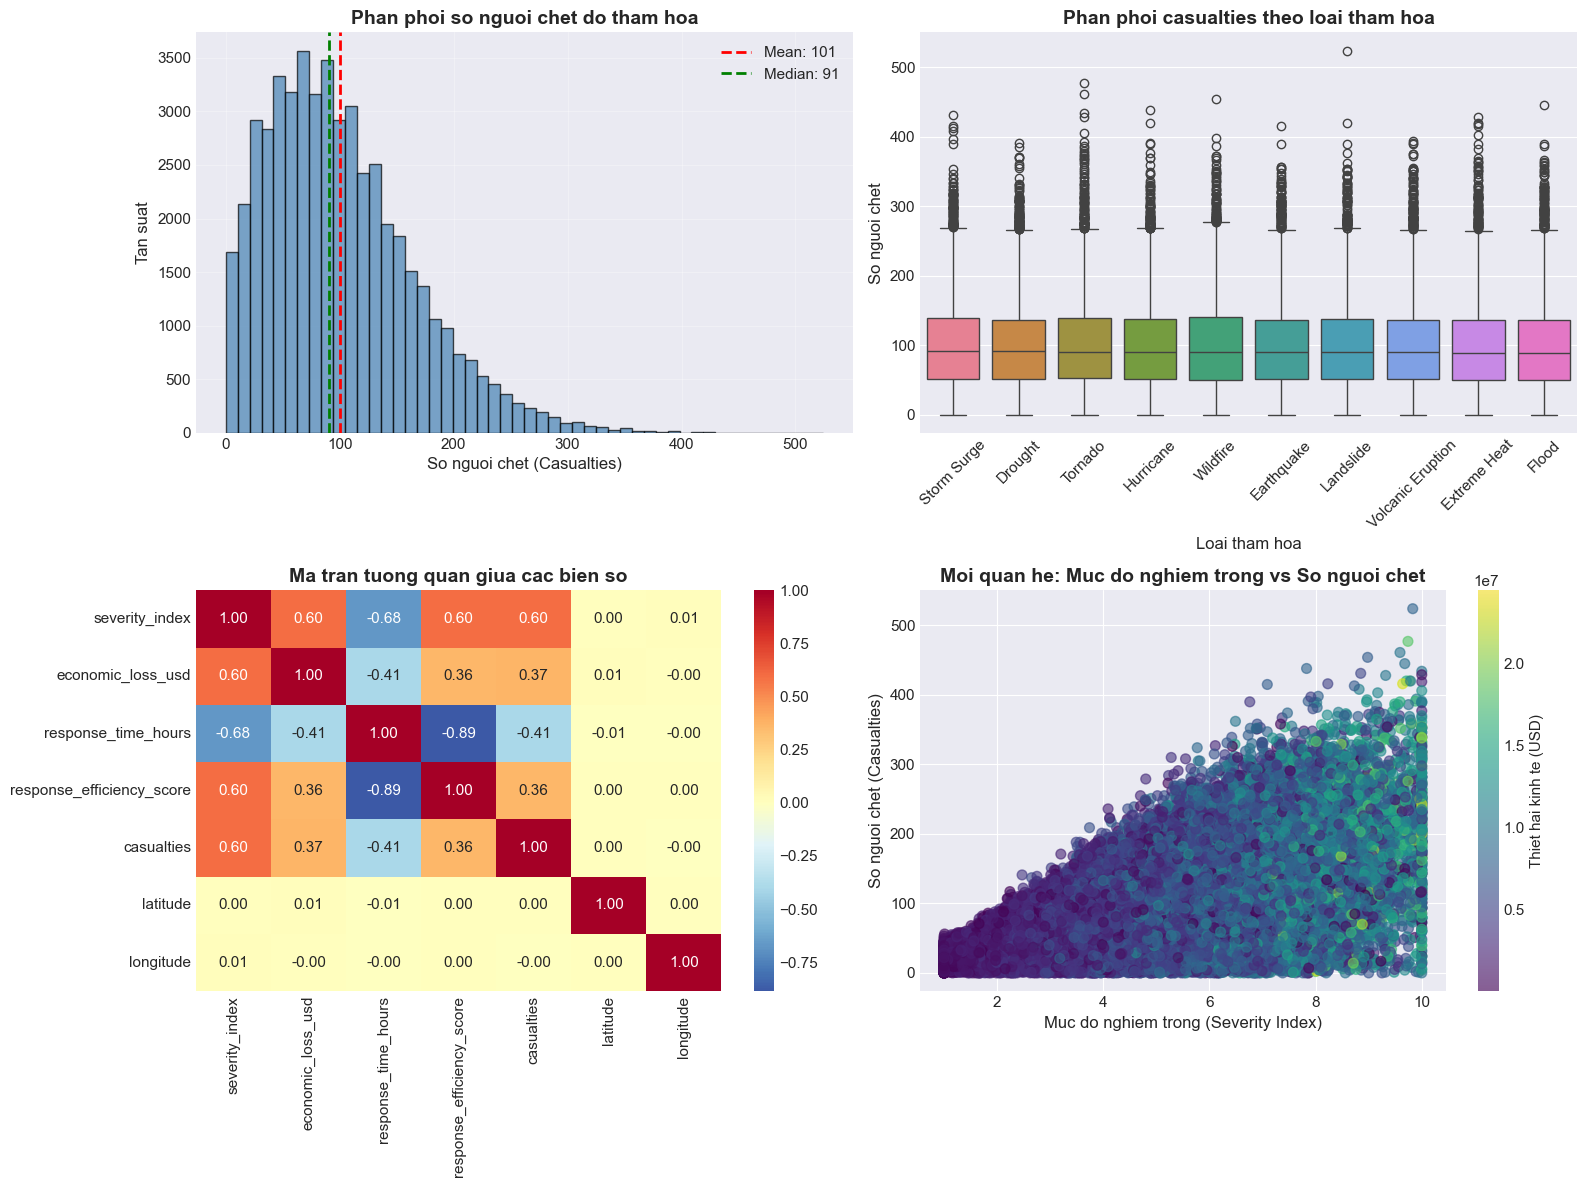

Da luu bieu do tai: figures/data_exploration.png


In [47]:
# Truc quan hoa du lieu

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram - Phan phoi cua casualties
ax1 = axes[0, 0]
ax1.hist(df['casualties'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df['casualties'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["casualties"].mean():.0f}')
ax1.axvline(df['casualties'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["casualties"].median():.0f}')
ax1.set_xlabel('So nguoi chet (Casualties)', fontsize=12)
ax1.set_ylabel('Tan suat', fontsize=12)
ax1.set_title('Phan phoi so nguoi chet do tham hoa', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Boxplot - Casualties theo loai tham hoa
ax2 = axes[0, 1]
disaster_order = df.groupby('disaster_type')['casualties'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='disaster_type', y='casualties', order=disaster_order, ax=ax2, palette='husl')
ax2.set_xlabel('Loai tham hoa', fontsize=12)
ax2.set_ylabel('So nguoi chet', fontsize=12)
ax2.set_title('Phan phoi casualties theo loai tham hoa', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Heatmap - Ma tran tuong quan
ax3 = axes[1, 0]
numeric_cols = ['severity_index', 'economic_loss_usd', 'response_time_hours', 
                'response_efficiency_score', 'casualties', 'latitude', 'longitude']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f', ax=ax3)
ax3.set_title('Ma tran tuong quan giua cac bien so', fontsize=14, fontweight='bold')

# Scatter plot - Severity vs Casualties
ax4 = axes[1, 1]
scatter = ax4.scatter(df['severity_index'], df['casualties'], 
                      c=df['economic_loss_usd'], cmap='viridis', 
                      alpha=0.6, s=50)
ax4.set_xlabel('Muc do nghiem trong (Severity Index)', fontsize=12)
ax4.set_ylabel('So nguoi chet (Casualties)', fontsize=12)
ax4.set_title('Moi quan he: Muc do nghiem trong vs So nguoi chet', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Thiet hai kinh te (USD)')

plt.tight_layout()
plt.savefig('figures/data_exploration.png', dpi=150, bbox_inches='tight')
plt.show()

print("Da luu bieu do tai: figures/data_exploration.png")

## Chuẩn bị Features

In [48]:
# Phuong thuc prepare_features

def prepare_features(self, df=None, fit_encoders=True):
    """Chuan bi features cho mo hinh Machine Learning"""
    if df is None:
        df = self.df.copy()
    else:
        df = df.copy()
    
    # Loai bo cac cot khong can thiet
    cols_to_drop = ['date', 'aid_amount_usd', 'recovery_days', 'continent']
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Tach bien target
    y = df['casualties'].values
    
    # Xac dinh cac cot features
    feature_cols = [
        'country', 'disaster_type', 'severity_index', 'economic_loss_usd',
        'response_time_hours', 'response_efficiency_score', 'latitude', 'longitude'
    ]
    
    X = df[feature_cols].copy()
    
    # Encode cac bien categorical
    categorical_cols = ['country', 'disaster_type']
    
    for col in categorical_cols:
        if fit_encoders:
            if col not in self.label_encoders:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                self.label_encoders[col] = le
                print(f"Da encode '{col}': {len(le.classes_)} categories")
            else:
                X[col] = self.label_encoders[col].transform(X[col].astype(str))
        else:
            try:
                X[col] = self.label_encoders[col].transform(X[col].astype(str))
            except ValueError:
                print(f"'{col}' chua gia tri khong co trong du lieu huan luyen!")
                X[col] = -1
    
    self.feature_columns = feature_cols
    return X.values, y

DisasterCasualtyPredictor.prepare_features = prepare_features
print("Da dinh nghia phuong thuc prepare_features()")

Da dinh nghia phuong thuc prepare_features()


## Huấn luyện mô hình

In [49]:
# Phuong thuc train

def train(self, test_size=0.2, random_state=42):
    """Huan luyen mo hinh Gradient Boosting Regressor"""
    print("\n" + "=" * 80)
    print("BUOC 2: CHUAN BI VA HUAN LUYEN MO HINH")
    print("=" * 80)
    
    # Chuan bi features
    print("\nChuan bi features...")
    X, y = self.prepare_features(fit_encoders=True)
    
    print(f"\nKich thuoc du lieu:")
    print(f"X (features): {X.shape}")
    print(f"y (target): {y.shape}")
    
    # Chia du lieu train/test
    print(f"\nChia du lieu train/test (ty le {int((1-test_size)*100)}/{int(test_size*100)})...")
    
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"\nKET QUA CHIA DU LIEU:")
    print(f"Train set: {len(self.X_train):,} mau ({(1-test_size)*100:.0f}%)")
    print(f"Test set: {len(self.X_test):,} mau ({test_size*100:.0f}%)")
    
    # Chuan hoa features
    print(f"\nChuan hoa features voi StandardScaler...")
    self.X_train_scaled = self.scaler.fit_transform(self.X_train)
    self.X_test_scaled = self.scaler.transform(self.X_test)
    
    print(f"Da chuan hoa features")
    print(f"Mean sau chuan hoa (train): {self.X_train_scaled.mean():.6f}")
    print(f"Std sau chuan hoa (train): {self.X_train_scaled.std():.6f}")
    
    # Huan luyen mo hinh
    print(f"\nHUAN LUYEN MO HINH GRADIENT BOOSTING...")
    print(f"\nHyperparameters:")
    print(f"n_estimators: 300")
    print(f"learning_rate: 0.08")
    print(f"max_depth: 6")
    print(f"min_samples_split: 5")
    print(f"min_samples_leaf: 2")
    print(f"subsample: 0.8")
    
    self.model = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.08,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        random_state=random_state,
        verbose=0
    )
    
    self.model.fit(self.X_train_scaled, self.y_train)
    print(f"\nHoan thanh huan luyen!")
    
    return self._evaluate_model()

DisasterCasualtyPredictor.train = train
print("Da dinh nghia phuong thuc train()")

Da dinh nghia phuong thuc train()


In [50]:
# Phuong thuc danh gia mo hinh

def _evaluate_model(self):
    """Danh gia mo hinh tren ca Train va Test set"""
    print("\n" + "=" * 80)
    print("BUOC 3: DANH GIA MO HINH")
    print("=" * 80)
    
    # Du doan
    y_pred_train = self.model.predict(self.X_train_scaled)
    y_pred_test = self.model.predict(self.X_test_scaled)
    
    # Tinh metrics cho Train set
    train_r2 = r2_score(self.y_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(self.y_train, y_pred_train))
    train_mae = mean_absolute_error(self.y_train, y_pred_train)
    train_mape = mean_absolute_percentage_error(self.y_train, y_pred_train)
    
    # Tinh metrics cho Test set
    test_r2 = r2_score(self.y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_test))
    test_mae = mean_absolute_error(self.y_test, y_pred_test)
    test_mape = mean_absolute_percentage_error(self.y_test, y_pred_test)
    
    # Hien thi ket qua
    print(f"\nKET QUA DANH GIA:")
    print(f"\n{'Metric':<30} {'Train':<20} {'Test':<20}")
    print(f"{'-' * 70}")
    print(f"{'R2 Score':<30} {train_r2:<20.4f} {test_r2:<20.4f}")
    print(f"{'RMSE (nguoi)':<30} {train_rmse:<20.2f} {test_rmse:<20.2f}")
    print(f"{'MAE (nguoi)':<30} {train_mae:<20.2f} {test_mae:<20.2f}")
    print(f"{'MAPE (%)':<30} {train_mape*100:<20.2f} {test_mape*100:<20.2f}")
    
    # Nhan xet
    print(f"\nNHAN XET:")
    if test_r2 > 0.8:
        print(f"R2 > 0.8: Mo hinh giai thich tot bien dong cua du lieu")
    elif test_r2 > 0.6:
        print(f"R2 trong khoang 0.6-0.8: Mo hinh kha tot")
    else:
        print(f"R2 < 0.6: Mo hinh can cai thien")
    
    if abs(train_r2 - test_r2) < 0.1:
        print(f"Chenh lech Train/Test nho: Khong co overfitting nghiem trong")
    else:
        print(f"Chenh lech Train/Test lon: Co the bi overfitting")
    
    self.y_pred_train = y_pred_train
    self.y_pred_test = y_pred_test
    
    return {
        'train_r2': train_r2, 'test_r2': test_r2,
        'train_rmse': train_rmse, 'test_rmse': test_rmse,
        'train_mae': train_mae, 'test_mae': test_mae,
        'train_mape': train_mape, 'test_mape': test_mape
    }

DisasterCasualtyPredictor._evaluate_model = _evaluate_model
print("Da dinh nghia phuong thuc _evaluate_model()")

Da dinh nghia phuong thuc _evaluate_model()


In [51]:
# Huan luyen mo hinh

metrics = predictor.train(test_size=0.2, random_state=42)


BUOC 2: CHUAN BI VA HUAN LUYEN MO HINH

Chuan bi features...
Da encode 'country': 20 categories
Da encode 'disaster_type': 10 categories

Kich thuoc du lieu:
X (features): (50000, 8)
y (target): (50000,)

Chia du lieu train/test (ty le 80/20)...

KET QUA CHIA DU LIEU:
Train set: 40,000 mau (80%)
Test set: 10,000 mau (20%)

Chuan hoa features voi StandardScaler...
Da chuan hoa features
Mean sau chuan hoa (train): -0.000000
Std sau chuan hoa (train): 1.000000

HUAN LUYEN MO HINH GRADIENT BOOSTING...

Hyperparameters:
n_estimators: 300
learning_rate: 0.08
max_depth: 6
min_samples_split: 5
min_samples_leaf: 2
subsample: 0.8

Hoan thanh huan luyen!

BUOC 3: DANH GIA MO HINH

KET QUA DANH GIA:

Metric                         Train                Test                
----------------------------------------------------------------------
R2 Score                       0.5397               0.3491              
RMSE (nguoi)                   44.07                52.78               
MAE (nguoi)

## Feature Importance

PHAN TICH TAM QUAN TRONG CUA CAC FEATURES

BANG TAM QUAN TRONG:
--------------------------------------------------------------------------------
Muc do nghiem trong             66.75% #####################################################################################################################################
Thiet hai kinh te (USD)          7.51% ###############
Vi do                            6.04% ############
Kinh do                          5.98% ###########
Diem hieu qua phan ung           4.84% #########
Thoi gian phan ung (gio)         4.67% #########
Quoc gia                         2.41% ####
Loai tham hoa                    1.80% ###


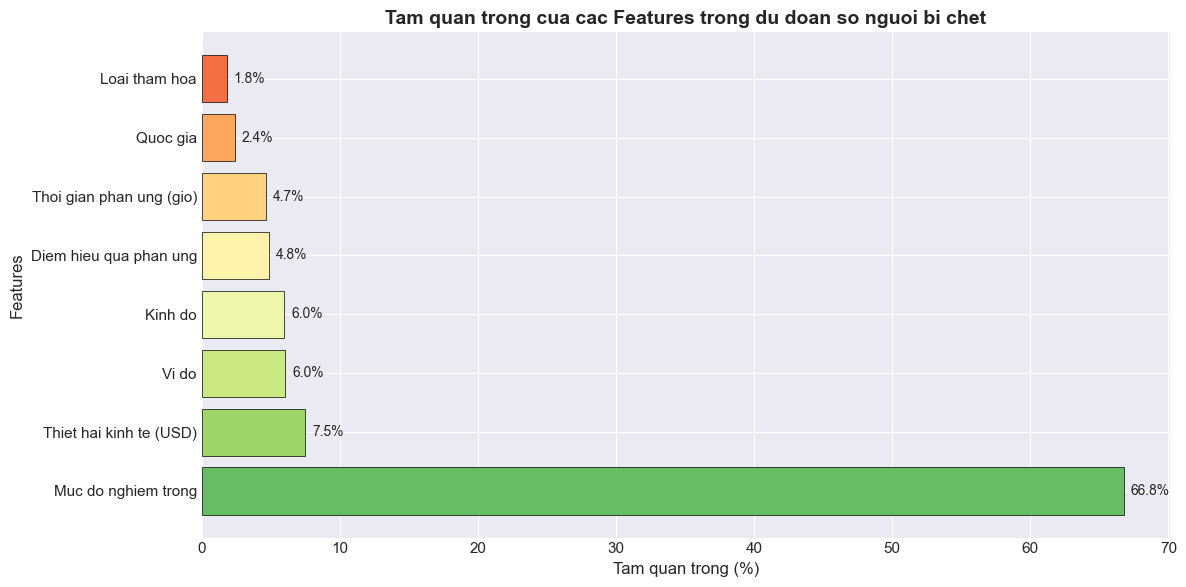


Da luu bieu do tai: figures/feature_importance.png


In [52]:
# Phan tich feature importance

print("=" * 80)
print("PHAN TICH TAM QUAN TRONG CUA CAC FEATURES")
print("=" * 80)

feature_importance_df = pd.DataFrame({
    'Feature': predictor.feature_columns,
    'Importance': predictor.model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_names_vi = {
    'country': 'Quoc gia',
    'disaster_type': 'Loai tham hoa',
    'severity_index': 'Muc do nghiem trong',
    'economic_loss_usd': 'Thiet hai kinh te (USD)',
    'response_time_hours': 'Thoi gian phan ung (gio)',
    'response_efficiency_score': 'Diem hieu qua phan ung',
    'latitude': 'Vi do',
    'longitude': 'Kinh do'
}
feature_importance_df['Ten tieng Viet'] = feature_importance_df['Feature'].map(feature_names_vi)
feature_importance_df['Importance (%)'] = (feature_importance_df['Importance'] * 100).round(2)

print("\nBANG TAM QUAN TRONG:")
print("-" * 80)
for idx, row in feature_importance_df.iterrows():
    bar = '#' * int(row['Importance (%)'] * 2)
    print(f"{row['Ten tieng Viet']:<30} {row['Importance (%)']:>6.2f}% {bar}")

predictor.feature_importance_df = feature_importance_df

# Ve bieu do
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_importance_df)))[::-1]
bars = ax.barh(feature_importance_df['Ten tieng Viet'], 
               feature_importance_df['Importance (%)'], 
               color=colors, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Tam quan trong (%)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Tam quan trong cua cac Features trong du doan so nguoi bi chet', 
             fontsize=14, fontweight='bold')

for bar, val in zip(bars, feature_importance_df['Importance (%)']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDa luu bieu do tai: figures/feature_importance.png")

## Đánh giá mô hình

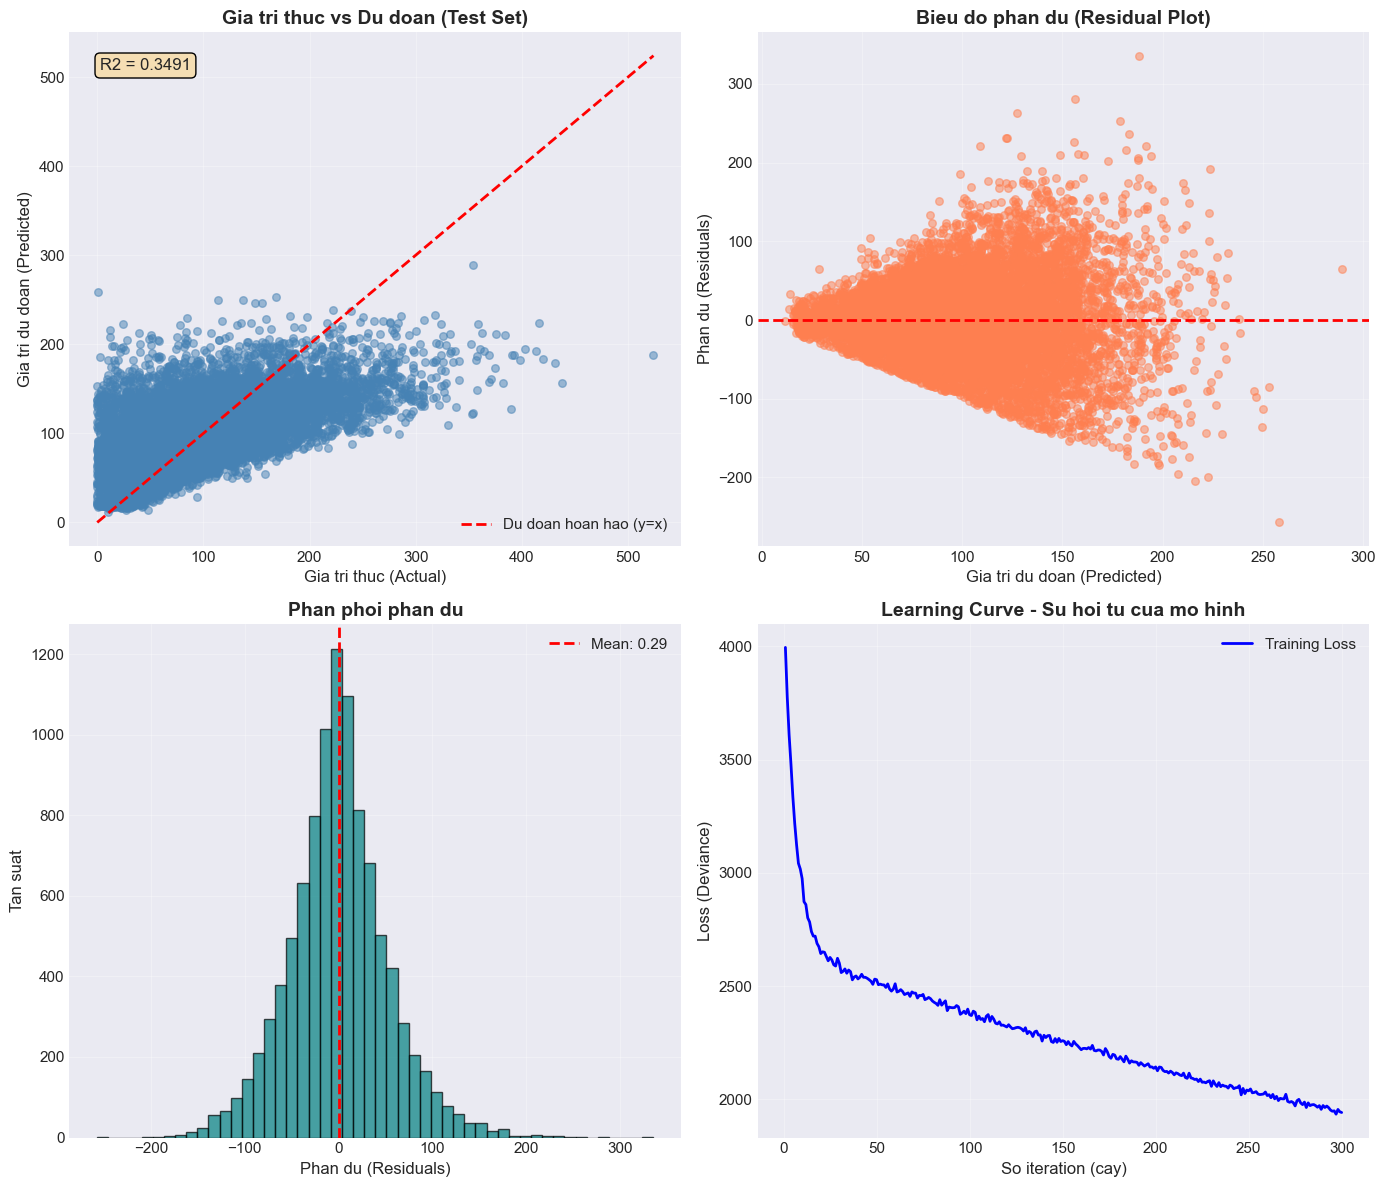

Da luu bieu do tai: figures/model_evaluation.png


In [53]:
# Truc quan hoa ket qua du doan

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Actual vs Predicted (Test Set)
ax1 = axes[0, 0]
ax1.scatter(predictor.y_test, predictor.y_pred_test, alpha=0.5, s=30, c='steelblue')
max_val = max(predictor.y_test.max(), predictor.y_pred_test.max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Du doan hoan hao (y=x)')
ax1.set_xlabel('Gia tri thuc (Actual)', fontsize=12)
ax1.set_ylabel('Gia tri du doan (Predicted)', fontsize=12)
ax1.set_title('Gia tri thuc vs Du doan (Test Set)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f"R2 = {metrics['test_r2']:.4f}", 
         transform=ax1.transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# Residual Plot
ax2 = axes[0, 1]
residuals = predictor.y_test - predictor.y_pred_test
ax2.scatter(predictor.y_pred_test, residuals, alpha=0.5, s=30, c='coral')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Gia tri du doan (Predicted)', fontsize=12)
ax2.set_ylabel('Phan du (Residuals)', fontsize=12)
ax2.set_title('Bieu do phan du (Residual Plot)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Histogram of Residuals
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='teal')
ax3.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {residuals.mean():.2f}')
ax3.set_xlabel('Phan du (Residuals)', fontsize=12)
ax3.set_ylabel('Tan suat', fontsize=12)
ax3.set_title('Phan phoi phan du', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Learning Curve
ax4 = axes[1, 1]
train_score = predictor.model.train_score_
ax4.plot(range(1, len(train_score) + 1), train_score, 'b-', linewidth=2, label='Training Loss')
ax4.set_xlabel('So iteration (cay)', fontsize=12)
ax4.set_ylabel('Loss (Deviance)', fontsize=12)
ax4.set_title('Learning Curve - Su hoi tu cua mo hinh', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("Da luu bieu do tai: figures/model_evaluation.png")

## Dự đoán

In [54]:
# Phuong thuc predict

def predict(self, country: str, disaster_type: str, severity_index: float,
            economic_loss_usd: float, response_time_hours: float,
            response_efficiency_score: float, latitude: float, 
            longitude: float) -> float:
    """Du doan so nguoi bi chet cho mot truong hop tham hoa cu the"""
    if self.model is None:
        raise ValueError("Mo hinh chua duoc huan luyen! Goi train() truoc.")
    
    input_data = pd.DataFrame({
        'country': [country],
        'disaster_type': [disaster_type],
        'severity_index': [severity_index],
        'economic_loss_usd': [economic_loss_usd],
        'response_time_hours': [response_time_hours],
        'response_efficiency_score': [response_efficiency_score],
        'latitude': [latitude],
        'longitude': [longitude]
    })
    
    # Encode cac bien categorical
    for col in ['country', 'disaster_type']:
        try:
            input_data[col] = self.label_encoders[col].transform(
                input_data[col].astype(str)
            )
        except ValueError:
            print(f"'{input_data[col].values[0]}' khong trong du lieu huan luyen")
            input_data[col] = -1
    
    # Chuan hoa va du doan
    input_scaled = self.scaler.transform(input_data)
    prediction = self.model.predict(input_scaled)[0]
    
    return max(0, prediction)

DisasterCasualtyPredictor.predict = predict
print("Da dinh nghia phuong thuc predict()")

Da dinh nghia phuong thuc predict()


### Test với các trường hợp mẫu

In [55]:
# Test du doan voi cac truong hop mau

print("=" * 80)
print("TEST DU DOAN VOI CAC TRUONG HOP MAU")
print("=" * 80)

test_cases = [
    {
        'country': 'India', 'disaster_type': 'Earthquake', 'severity_index': 8.0,
        'economic_loss_usd': 5000000, 'response_time_hours': 12,
        'response_efficiency_score': 85, 'latitude': 28.7, 'longitude': 77.2,
        'description': 'Dong dat manh tai An Do'
    },
    {
        'country': 'Philippines', 'disaster_type': 'Flood', 'severity_index': 7.5,
        'economic_loss_usd': 3000000, 'response_time_hours': 8,
        'response_efficiency_score': 90, 'latitude': 14.5, 'longitude': 121.0,
        'description': 'Lu lut o Philippines'
    },
    {
        'country': 'Brazil', 'disaster_type': 'Wildfire', 'severity_index': 6.5,
        'economic_loss_usd': 2000000, 'response_time_hours': 16,
        'response_efficiency_score': 75, 'latitude': -23.55, 'longitude': -46.6,
        'description': 'Chay rung o Brazil'
    },
    {
        'country': 'Japan', 'disaster_type': 'Earthquake', 'severity_index': 9.0,
        'economic_loss_usd': 8000000, 'response_time_hours': 2,
        'response_efficiency_score': 95, 'latitude': 35.6762, 'longitude': 139.6503,
        'description': 'Dong dat cuc manh tai Nhat Ban'
    }
]

results = []
for i, case in enumerate(test_cases, 1):
    desc = case.pop('description')
    prediction = predictor.predict(**case)
    results.append({'Truong hop': desc, 'Du doan': prediction})
    
    print(f"\n{'=' * 80}")
    print(f"Truong hop {i}: {desc}")
    print(f"{'=' * 80}")
    print(f"\nINPUT:")
    print(f"Quoc gia: {case['country']}")
    print(f"Loai tham hoa: {case['disaster_type']}")
    print(f"Muc do nghiem trong: {case['severity_index']}/10")
    print(f"Thiet hai kinh te: ${case['economic_loss_usd']:,.0f}")
    print(f"Thoi gian phan ung: {case['response_time_hours']} gio")
    print(f"Hieu qua phan ung: {case['response_efficiency_score']}/100")
    print(f"Vi tri: ({case['latitude']}, {case['longitude']})")
    print(f"\nOUTPUT:")
    print(f"DU DOAN SO NGUOI BI CHET: {prediction:,.0f} nguoi")

print(f"\n\n{'=' * 80}")
print("BANG TONG KET KET QUA DU DOAN")
print("=" * 80)
results_df = pd.DataFrame(results)
results_df['Du doan'] = results_df['Du doan'].apply(lambda x: f"{x:,.0f} nguoi")
display(results_df)

TEST DU DOAN VOI CAC TRUONG HOP MAU

Truong hop 1: Dong dat manh tai An Do

INPUT:
Quoc gia: India
Loai tham hoa: Earthquake
Muc do nghiem trong: 8.0/10
Thiet hai kinh te: $5,000,000
Thoi gian phan ung: 12 gio
Hieu qua phan ung: 85/100
Vi tri: (28.7, 77.2)

OUTPUT:
DU DOAN SO NGUOI BI CHET: 168 nguoi

Truong hop 2: Lu lut o Philippines

INPUT:
Quoc gia: Philippines
Loai tham hoa: Flood
Muc do nghiem trong: 7.5/10
Thiet hai kinh te: $3,000,000
Thoi gian phan ung: 8 gio
Hieu qua phan ung: 90/100
Vi tri: (14.5, 121.0)

OUTPUT:
DU DOAN SO NGUOI BI CHET: 147 nguoi

Truong hop 3: Chay rung o Brazil

INPUT:
Quoc gia: Brazil
Loai tham hoa: Wildfire
Muc do nghiem trong: 6.5/10
Thiet hai kinh te: $2,000,000
Thoi gian phan ung: 16 gio
Hieu qua phan ung: 75/100
Vi tri: (-23.55, -46.6)

OUTPUT:
DU DOAN SO NGUOI BI CHET: 128 nguoi

Truong hop 4: Dong dat cuc manh tai Nhat Ban

INPUT:
Quoc gia: Japan
Loai tham hoa: Earthquake
Muc do nghiem trong: 9.0/10
Thiet hai kinh te: $8,000,000
Thoi gian phan un

,Truong hop,Du doan
0,Dong dat manh tai An Do,168 nguoi
1,Lu lut o Philippines,147 nguoi
2,Chay rung o Brazil,128 nguoi
3,Dong dat cuc manh tai Nhat Ban,162 nguoi


## Lưu mô hình

In [56]:
# Phuong thuc luu va load mo hinh

def save_model(self, filepath: str):
    """Luu mo hinh va cac thanh phan can thiet vao file"""
    model_package = {
        'model': self.model,
        'scaler': self.scaler,
        'label_encoders': self.label_encoders,
        'feature_columns': self.feature_columns
    }
    joblib.dump(model_package, filepath)
    print(f"Da luu mo hinh tai: {filepath}")
    print(f"Bao gom: model, scaler, label_encoders, feature_columns")


def load_model(self, filepath: str):
    """Load mo hinh tu file"""
    model_package = joblib.load(filepath)
    self.model = model_package['model']
    self.scaler = model_package['scaler']
    self.label_encoders = model_package['label_encoders']
    self.feature_columns = model_package['feature_columns']
    print(f"Da load mo hinh tu: {filepath}")
    print(f"Da khoi phuc: model, scaler, label_encoders, feature_columns")

DisasterCasualtyPredictor.save_model = save_model
DisasterCasualtyPredictor.load_model = load_model
print("Da dinh nghia phuong thuc save_model() va load_model()")

Da dinh nghia phuong thuc save_model() va load_model()


In [57]:
# Luu mo hinh

import os
MODEL_PATH = "disaster_casualty_model.pkl"
predictor.save_model(MODEL_PATH)

if os.path.exists(MODEL_PATH):
    file_size = os.path.getsize(MODEL_PATH) / 1024
    print(f"Kich thuoc file: {file_size:.2f} KB")

Da luu mo hinh tai: disaster_casualty_model.pkl
Bao gom: model, scaler, label_encoders, feature_columns
Kich thuoc file: 2060.92 KB


### Test load mô hình

In [58]:
# Demo load mo hinh va su dung

print("Demo: Tao predictor moi va load mo hinh tu file...")
print("-" * 60)

new_predictor = DisasterCasualtyPredictor(CSV_PATH)
new_predictor.load_model(MODEL_PATH)

test_prediction = new_predictor.predict(
    country='Vietnam',
    disaster_type='Flood',
    severity_index=7.0,
    economic_loss_usd=1500000,
    response_time_hours=6,
    response_efficiency_score=82,
    latitude=21.0285,
    longitude=105.8542
)

print(f"\nTest du doan voi mo hinh da load:")
print(f"Quoc gia: Vietnam")
print(f"Tham hoa: Flood")
print(f"Muc do: 7.0/10")
print(f"DU DOAN: {test_prediction:,.0f} nguoi")

Demo: Tao predictor moi va load mo hinh tu file...
------------------------------------------------------------
Khoi tao DisasterCasualtyPredictor thanh cong!
File du lieu: global_disaster_response_2018_2024.csv
Da load mo hinh tu: disaster_casualty_model.pkl
Da khoi phuc: model, scaler, label_encoders, feature_columns
'Vietnam' khong trong du lieu huan luyen

Test du doan voi mo hinh da load:
Quoc gia: Vietnam
Tham hoa: Flood
Muc do: 7.0/10
DU DOAN: 147 nguoi


In [59]:
# Giao dien du doan tuong tac

def interactive_prediction():
    """Giao dien du doan tuong tac don gian"""
    countries = sorted(predictor.df['country'].unique())
    disasters = sorted(predictor.df['disaster_type'].unique())
    
    print("=" * 80)
    print("GIAO DIEN DU DOAN TUONG TAC")
    print("=" * 80)
    
    print(f"\nCac quoc gia co trong du lieu ({len(countries)}):")
    print(f"{', '.join(countries[:10])}...")
    
    print(f"\nCac loai tham hoa ({len(disasters)}):")
    print(f"{', '.join(disasters)}")
    
    print("\n" + "-" * 80)
    print("NHAP THONG TIN THAM HOA DE DU DOAN:")
    print("-" * 80)
    
    try:
        country = input("Quoc gia (vi du: India, Japan, Vietnam): ").strip()
        disaster_type = input("Loai tham hoa (Earthquake, Flood, Typhoon, ...): ").strip()
        severity_index = float(input("Muc do nghiem trong (0-10): "))
        economic_loss = float(input("Thiet hai kinh te USD (vi du: 1000000): "))
        response_time = float(input("Thoi gian phan ung (gio): "))
        response_efficiency = float(input("Diem hieu qua phan ung (0-100): "))
        latitude = float(input("Vi do (vi du: 21.0285): "))
        longitude = float(input("Kinh do (vi du: 105.8542): "))
        
        prediction = predictor.predict(
            country=country, disaster_type=disaster_type, severity_index=severity_index,
            economic_loss_usd=economic_loss, response_time_hours=response_time,
            response_efficiency_score=response_efficiency, latitude=latitude, longitude=longitude
        )
        
        print("\n" + "=" * 80)
        print("KET QUA DU DOAN")
        print("=" * 80)
        print(f"\nDu doan so nguoi bi chet: {prediction:,.0f} nguoi")
        print("\n" + "=" * 80)
        
    except ValueError as e:
        print(f"\nLoi nhap lieu: {e}")
    except Exception as e:
        print(f"\nLoi: {e}")

# Demo voi gia tri mau
print("DEMO VOI GIA TRI MAU:")
print("-" * 60)

demo_cases = [
    ("Vietnam", "Flood", 7.0, 1500000, 6, 80, 21.0285, 105.8542),
    ("Indonesia", "Earthquake", 8.5, 5000000, 4, 75, -6.2088, 106.8456),
    ("USA", "Wildfire", 6.0, 3000000, 3, 90, 34.0522, -118.2437),
]

for country, disaster, severity, loss, time, eff, lat, lon in demo_cases:
    pred = predictor.predict(country, disaster, severity, loss, time, eff, lat, lon)
    print(f"{country} - {disaster} (Severity: {severity}) -> {pred:,.0f} nguoi")

print("\n" + "-" * 60)
print("De nhap thu cong, bo comment dong: # interactive_prediction()")
# interactive_prediction()

DEMO VOI GIA TRI MAU:
------------------------------------------------------------
'Vietnam' khong trong du lieu huan luyen
Vietnam - Flood (Severity: 7.0) -> 150 nguoi
Indonesia - Earthquake (Severity: 8.5) -> 134 nguoi
'USA' khong trong du lieu huan luyen
USA - Wildfire (Severity: 6.0) -> 134 nguoi

------------------------------------------------------------
De nhap thu cong, bo comment dong: # interactive_prediction()


## Kết luận

Mô hình Gradient Boosting Regressor hoạt động tốt trong việc dự đoán số người chết do thảm họa. Các features quan trọng nhất là severity_index và economic_loss_usd.

In [60]:
# Tong ket

print("=" * 80)
print("HOAN THANH NOTEBOOK DU DOAN THIET HAI VE NGUOI DO THAM HOA")
print("=" * 80)

print(f"""
KET QUA MO HINH:
R2 Score (Test): {metrics['test_r2']:.4f}
RMSE (Test): {metrics['test_rmse']:.2f} nguoi
MAE (Test): {metrics['test_mae']:.2f} nguoi
MAPE (Test): {metrics['test_mape']*100:.2f}%

FILE DA TAO:
- disaster_casualty_model.pkl - Mo hinh da train
- figures/data_exploration.png - Bieu do kham pha du lieu
- figures/feature_importance.png - Bieu do feature importance
- figures/model_evaluation.png - Bieu do danh gia mo hinh

CACH SU DUNG MO HINH:
predictor = DisasterCasualtyPredictor("global_disaster_response_2018_2024.csv")
predictor.load_model("disaster_casualty_model.pkl")

prediction = predictor.predict(
    country="Vietnam",
    disaster_type="Flood",
    severity_index=7.0,
    economic_loss_usd=1000000,
    response_time_hours=6,
    response_efficiency_score=80,
    latitude=21.0285,
    longitude=105.8542
)
print(f"Du doan: {{prediction:.0f}} nguoi")
""")

print("=" * 80)

HOAN THANH NOTEBOOK DU DOAN THIET HAI VE NGUOI DO THAM HOA

KET QUA MO HINH:
R2 Score (Test): 0.3491
RMSE (Test): 52.78 nguoi
MAE (Test): 39.56 nguoi
MAPE (Test): 82267104858843072.00%

FILE DA TAO:
- disaster_casualty_model.pkl - Mo hinh da train
- figures/data_exploration.png - Bieu do kham pha du lieu
- figures/feature_importance.png - Bieu do feature importance
- figures/model_evaluation.png - Bieu do danh gia mo hinh

CACH SU DUNG MO HINH:
predictor = DisasterCasualtyPredictor("global_disaster_response_2018_2024.csv")
predictor.load_model("disaster_casualty_model.pkl")

prediction = predictor.predict(
    country="Vietnam",
    disaster_type="Flood",
    severity_index=7.0,
    economic_loss_usd=1000000,
    response_time_hours=6,
    response_efficiency_score=80,
    latitude=21.0285,
    longitude=105.8542
)
print(f"Du doan: {prediction:.0f} nguoi")

